# Is Unrooted GNC a Reasonable Proxy for Rooted GNC?
### Setup

In [10]:
import os

from IPython.display import Markdown, display, Image
from numpy import average, std, array, round, sqrt
from pymongo import MongoClient
from pandas import DataFrame, set_option

In [11]:
%load_ext rpy2.ipython
%R library(ggplot2)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='|S9')

In [22]:
try:
    os.mkdir('bias_bias')
except OSError:
    pass

In [12]:
client = MongoClient()

In [13]:
truth = client.mammals.GNC_picked2
proxy = client.mammals.GNC_picked_sims2
fits = (
    ('Y98', client.mammals.Y98_picked_sims2),
    ('CNFGTR', client.mammals.CNFGTR_picked_sims2)
)
taxa = ['Mouse','Human','Opossum']

In [19]:
def stats_for_model(gen, fits, taxa):
    real_ens = {t.encode('utf-8'):d for t,d in gen['lf']['EN'].items()}
    real_ens['Opossum'] += real_ens['internal']
    real_omega = {t:o['bin0'] for t,o in gen['lf']['params']['omega'].items()}
    
    proxy_ens = {}
    proxy_omega = {}
    for taxon in taxa:
        ens = {}
        omega = {}
        for fit in proxy.find({'_id' : { '$regex' : '^'+doc['_id'] }}):
#            if fit['lf']['params']['omega'][taxon]['bin0'] < 100:
            ens[fit['_id']] = fit['lf']['EN'][taxon]
            omega[fit['_id']] = fit['lf']['params']['omega'][taxon]['bin0']
        proxy_ens[taxon] = ens
        proxy_omega[taxon] = omega
    
    rows = []
    for model, col in fits:
        for taxon in taxa:
            real_ens_bias = []
            proxy_ens_bias = []
            real_omega_bias = []
            proxy_omega_bias = []
            for fit in col.find({'_id' : { '$regex' : '^'+doc['_id'] }}):
                if fit['lf']['params']['omega'][taxon]['bin0'] >= 100:
                    print fit['_id']
                    continue
                real_ens_bias.append(fit['lf']['EN'][taxon] - real_ens[taxon])
                proxy_ens_bias.append(fit['lf']['EN'][taxon] - proxy_ens[taxon][fit['_id']])
                real_omega_bias.append(fit['lf']['params']['omega'][taxon]['bin0'] - real_omega[taxon])
                proxy_omega_bias.append(fit['lf']['params']['omega'][taxon]['bin0'] - proxy_omega[taxon][fit['_id']])
            rows.append((average(real_ens_bias), average(proxy_ens_bias), model, 'ENS', taxon))
            rows.append((average(real_omega_bias), average(proxy_omega_bias), model, 'omega', taxon))
    return {'columns' : ('real_bias', 'proxy_bias', 'model', 'parameter', 'branch'), 'rows' : rows}    

def printmd(string):
    ''' thanks http://stackoverflow.com/questions/32026727/format-output-of-code-cell-with-markdown '''
    display(Markdown(string))

In [21]:
rows = []
for doc in truth.find():
    stats = stats_for_model(doc, fits, taxa)
    rows.extend(stats['rows'])
    columns = stats['columns']
df = DataFrame(rows, columns=columns)

ENSG00000005436_mammals_63
ENSG00000005436_mammals_63
ENSG00000162614_mammals_11
ENSG00000162614_mammals_67
ENSG00000172061_mammals_20
ENSG00000172061_mammals_40
ENSG00000172061_mammals_55
ENSG00000172061_mammals_74
ENSG00000172061_mammals_83
ENSG00000106443_mammals_05
ENSG00000106443_mammals_47
ENSG00000139517_mammals_50
ENSG00000176371_mammals_09
ENSG00000176371_mammals_18
ENSG00000176371_mammals_21
ENSG00000176371_mammals_22
ENSG00000176371_mammals_29
ENSG00000176371_mammals_30
ENSG00000176371_mammals_31
ENSG00000176371_mammals_40
ENSG00000176371_mammals_44
ENSG00000176371_mammals_47
ENSG00000176371_mammals_52
ENSG00000176371_mammals_56
ENSG00000176371_mammals_58
ENSG00000176371_mammals_75
ENSG00000176371_mammals_78
ENSG00000176371_mammals_79
ENSG00000176371_mammals_81
ENSG00000176371_mammals_82
ENSG00000176371_mammals_83
ENSG00000176371_mammals_91
ENSG00000176371_mammals_92
ENSG00000176371_mammals_97
ENSG00000176371_mammals_09
ENSG00000176371_mammals_22
ENSG00000176371_mammals_29
E

In [23]:
%%R
get_ggplot <- function(df, parameter_name, branch_name)
{
    ggplot(df) +
        geom_point(aes(proxy_bias, real_bias, colour = factor(model))) +
        xlab('Real Bias') +
        ylab('Proxy Bias') +
        ggtitle(paste(branch_name, parameter_name))
}

#### Human omega

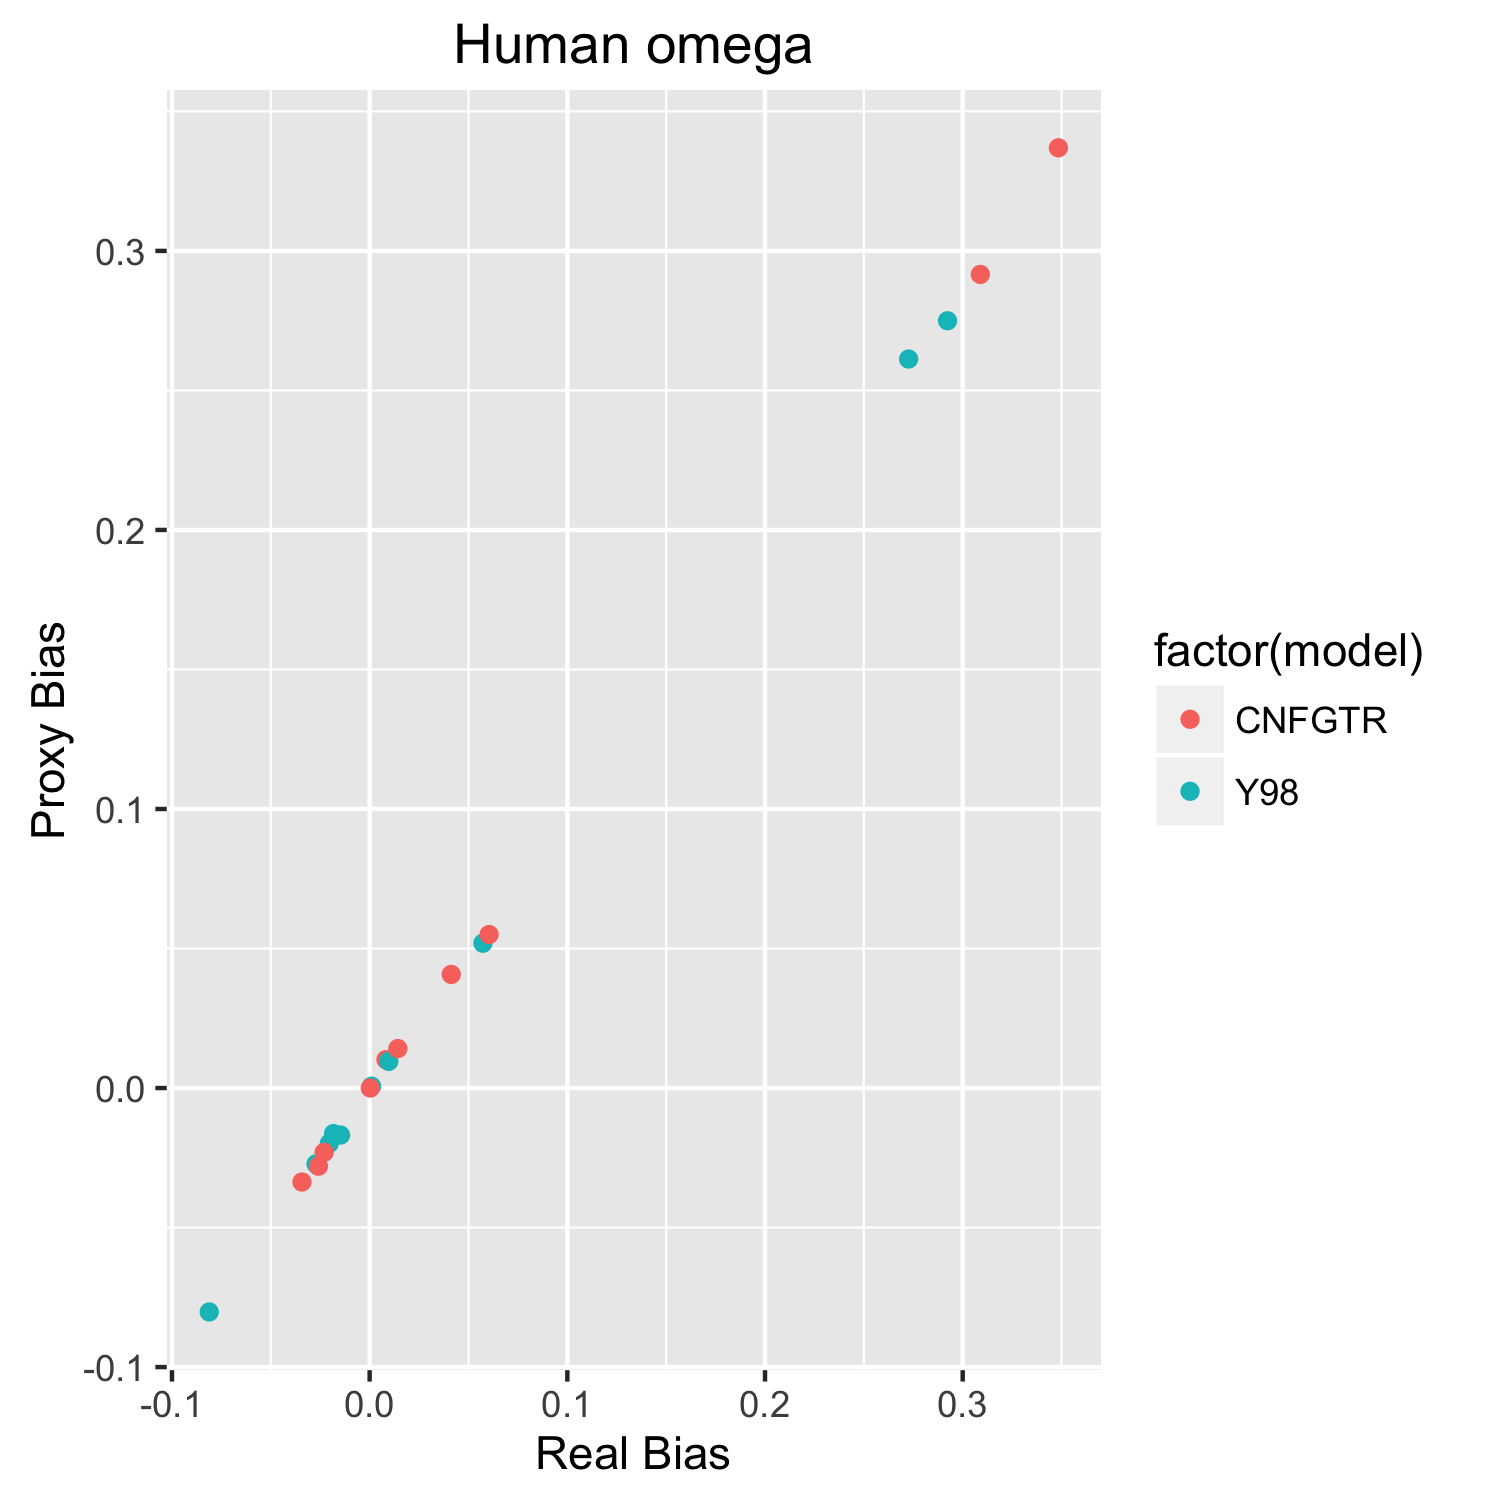

#### Mouse omega

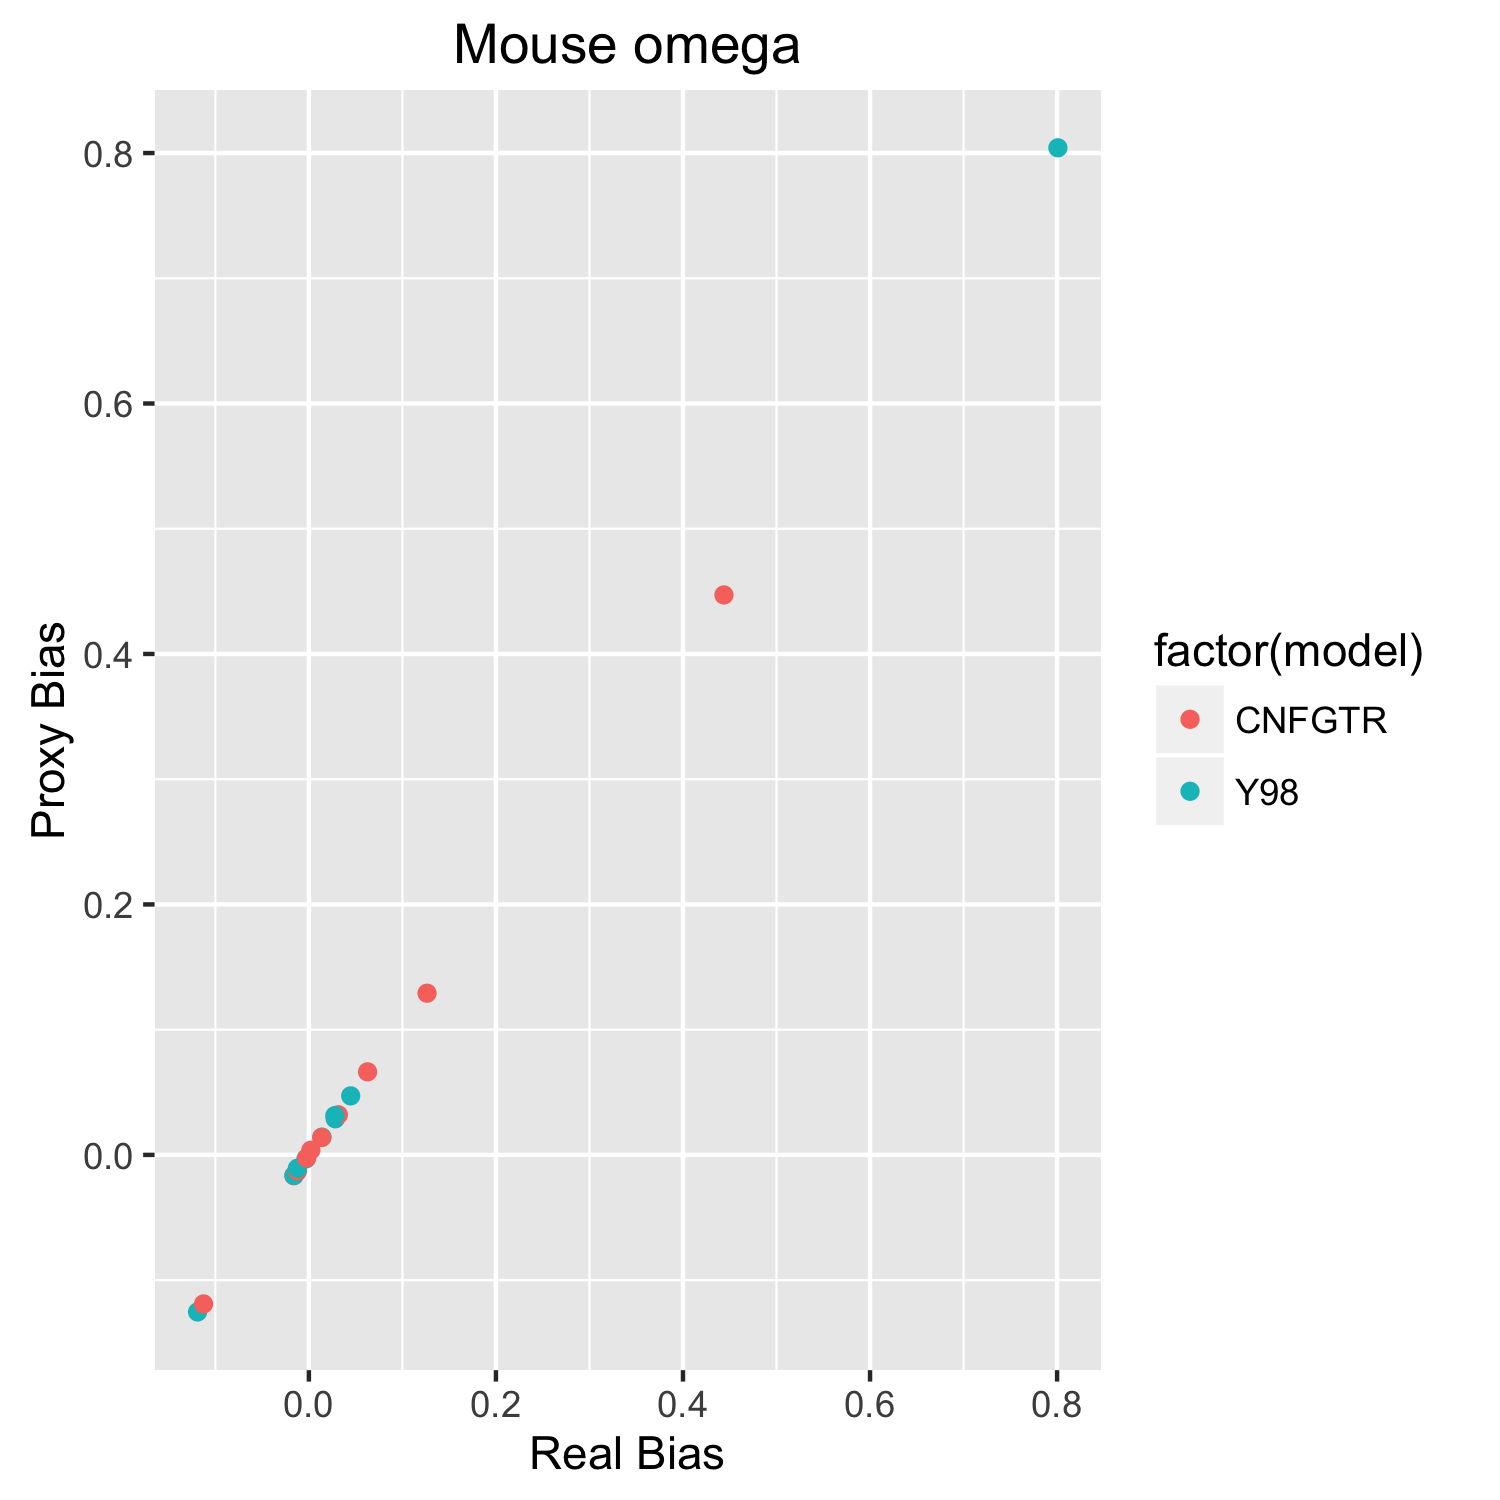

#### Opossum omega

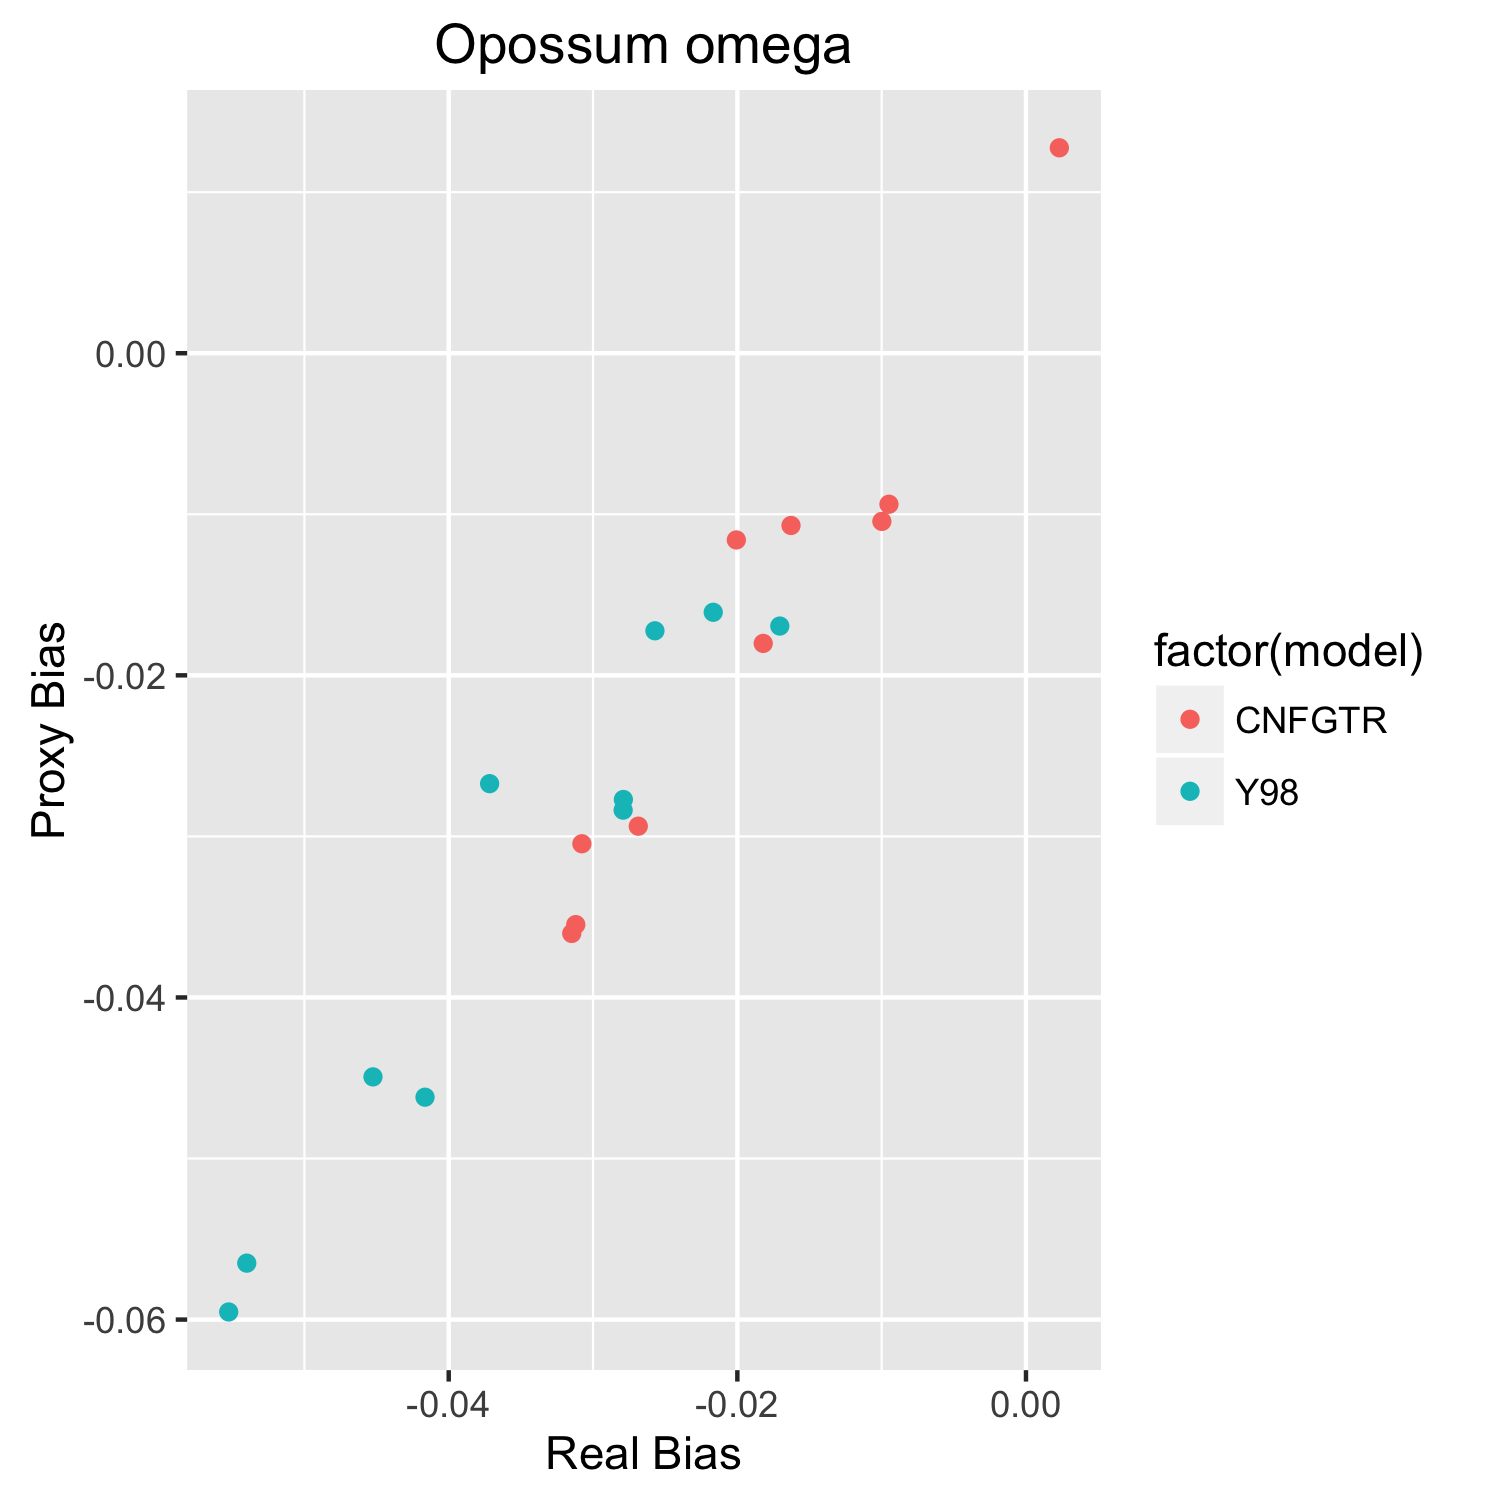

#### Human ENS

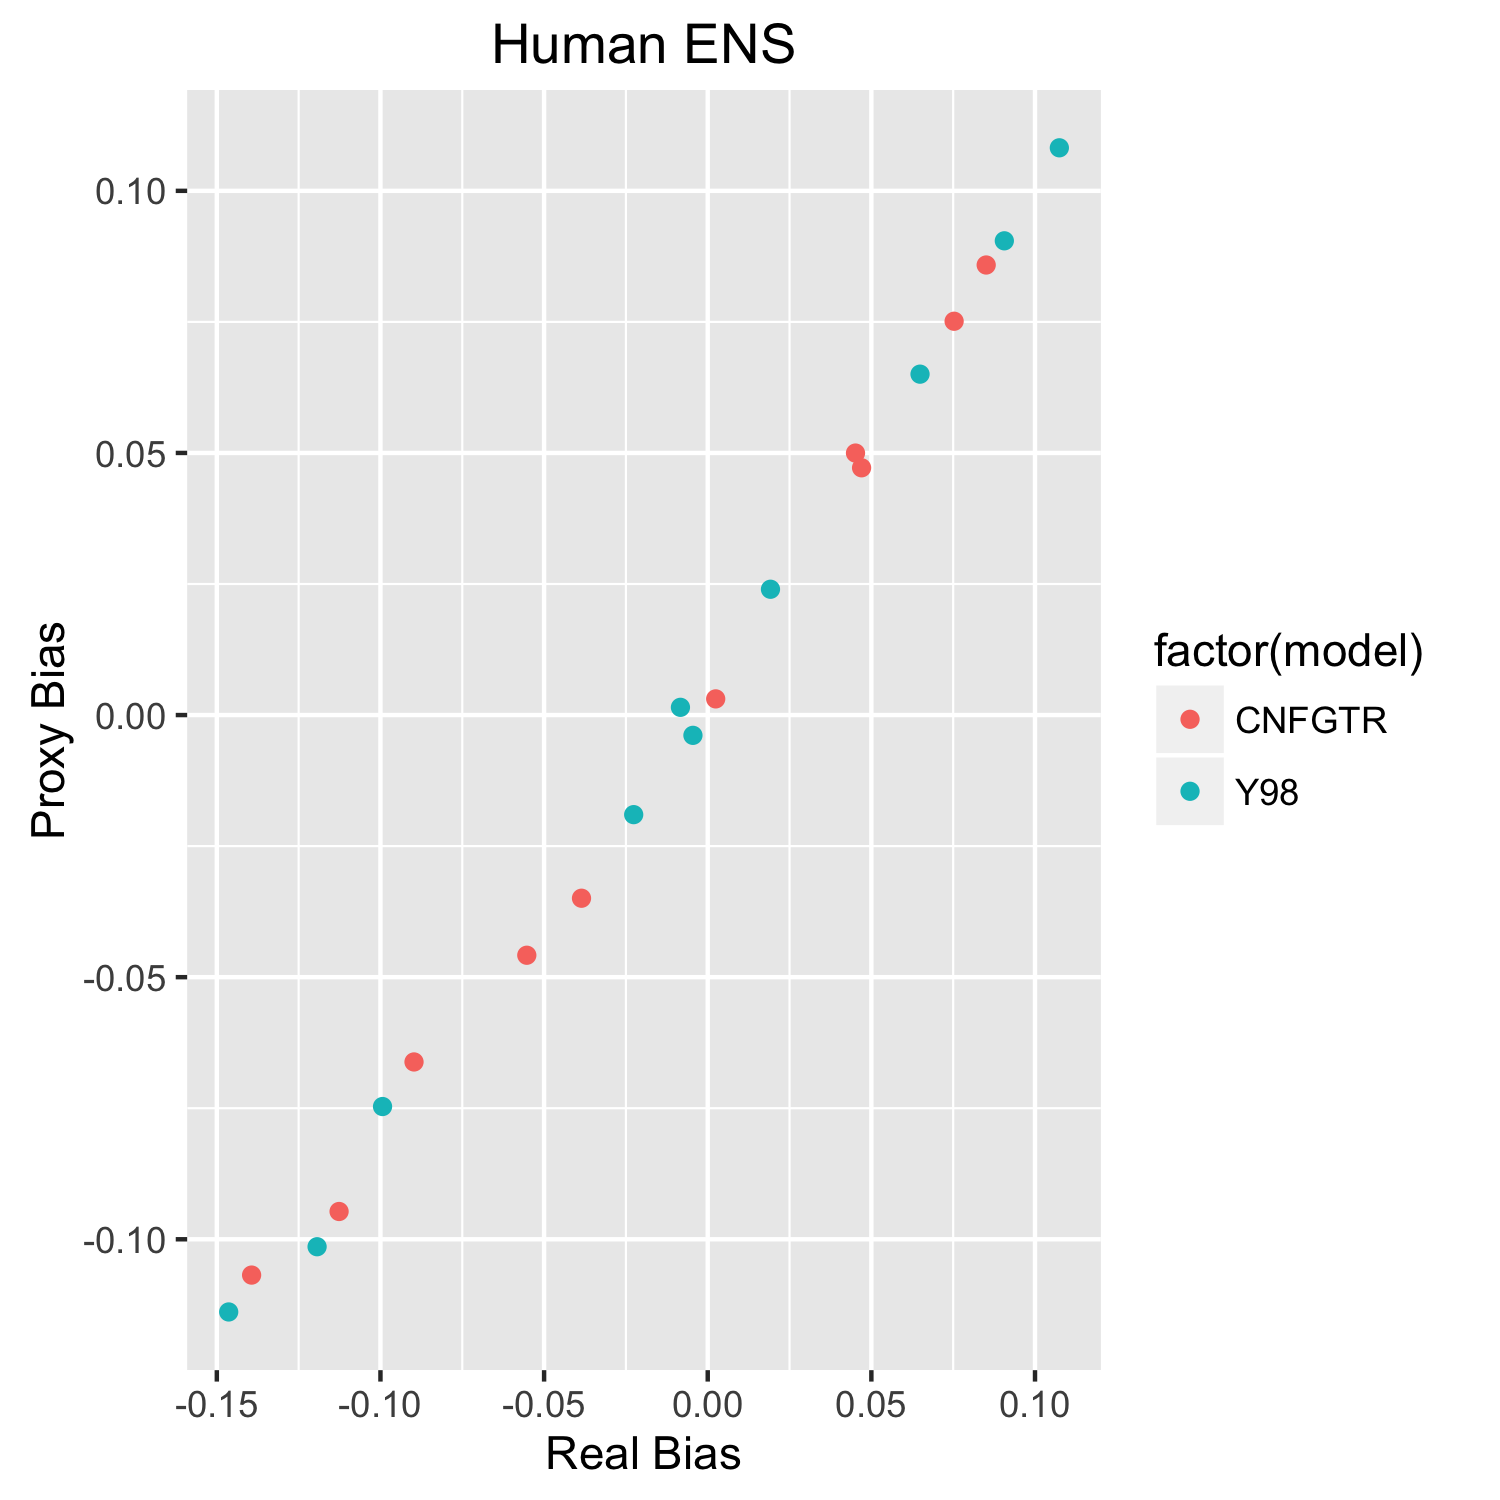

#### Mouse ENS

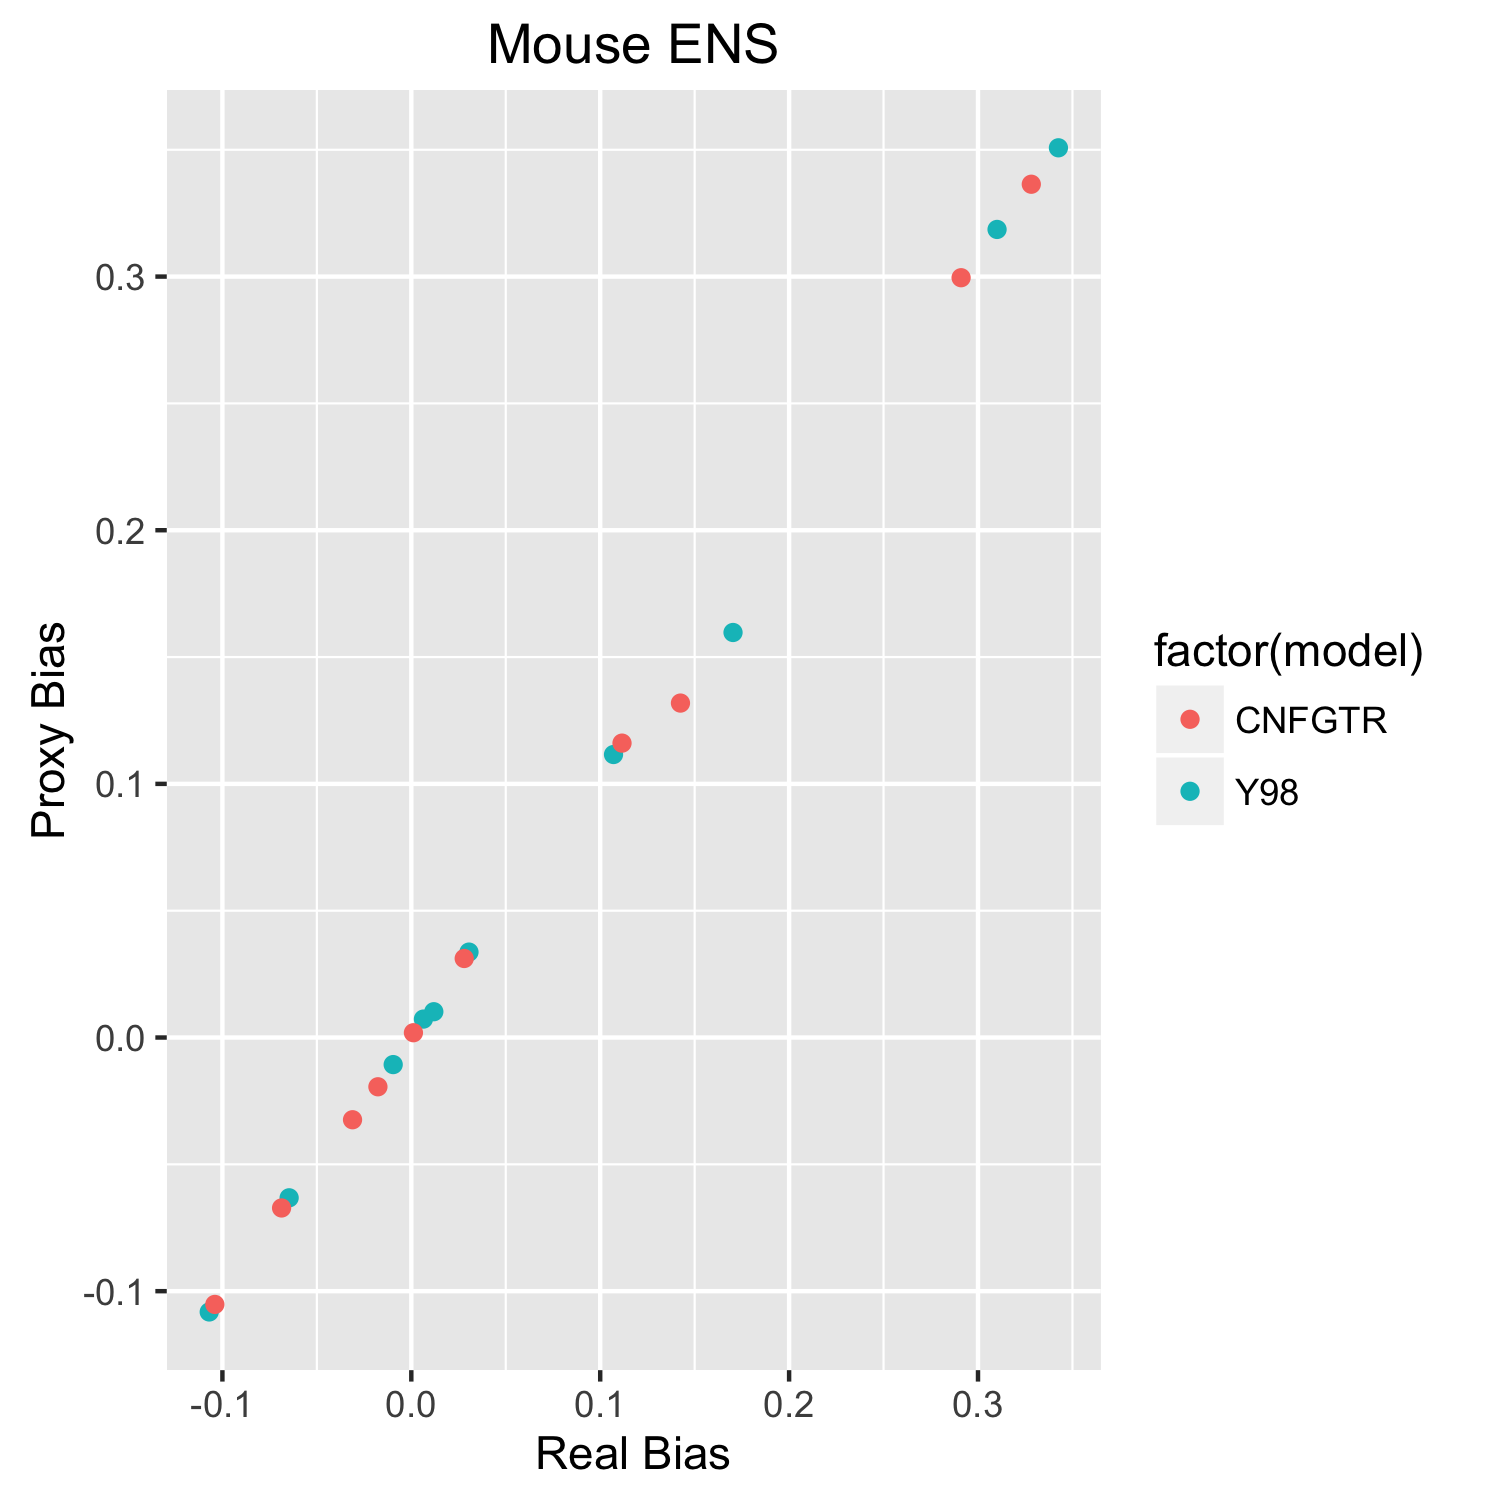

#### Opossum ENS

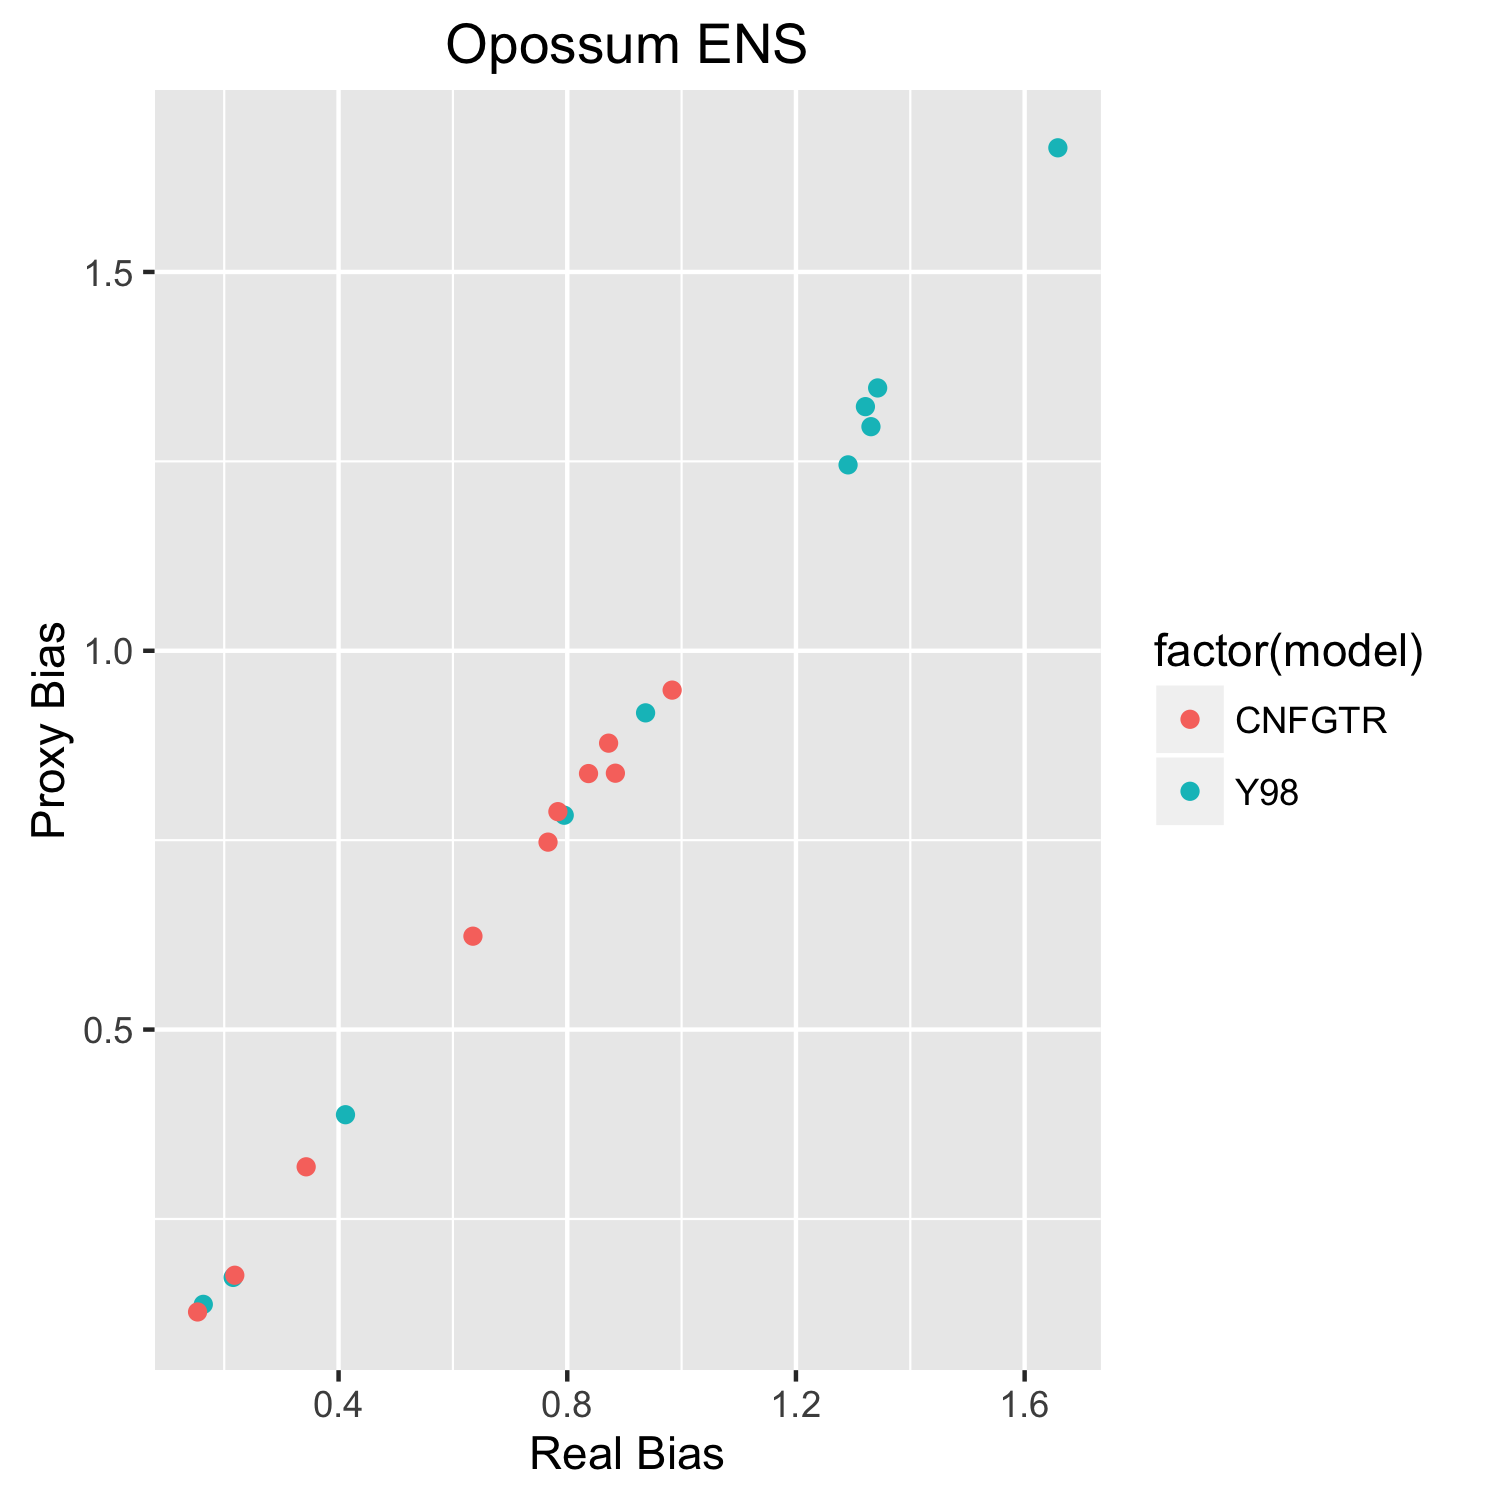

In [24]:
for parameter in 'omega', 'ENS':
    for branch in 'Human', 'Mouse', 'Opossum':
        printmd(' '.join(('####', branch, parameter)))
        name = os.path.join('bias_bias', '_'.join((parameter, branch)) + '.png')
        thisdf = df[df['parameter'] == parameter]
        thisdf = thisdf[thisdf['branch'] == branch]
        %R -i thisdf,parameter,branch gg <- get_ggplot(thisdf,parameter,branch)
        %R -i name ggsave(name, gg, width=5, height=5)
        display(Image(name))